In [23]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

import act_max_util as amu

from autoencoder import *
from solver import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [3]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [4]:
test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_images = test_images.squeeze(1)

In [29]:
def load_model(model_path, linearity, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    hidden_layers = sae_n_hidden_ls if model_type == 'SAE' else dae_n_hidden_ls
    model_class = LinearAutoencoder if linearity == 'l_models' else NonLinearAutoencoder
    model = model_class(n_input, hidden_layers, n_layers)

    weights = torch.load(f"{model_path}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [6]:
def evaluate_models(test_images, sae, dae):
    sae_activations = []
    dae_activations = []
    
    for i in range(len(test_images)):
        test_image = torch.tensor(test_images[i], dtype=torch.float32).reshape(-1)

        with torch.no_grad():
            encoded, _ = sae(test_image)
            sae_encoded = torch.abs(encoded)
            sae_activations.append(sae_encoded)

            encoded, _ = dae(test_image)
            dae_encoded = torch.abs(encoded)
            dae_activations.append(dae_encoded)
        
    return np.mean(np.vstack(sae_activations), axis=0), np.mean(np.vstack(dae_activations), axis=0)

In [7]:
def plot_average_activation(results):
    plt.figure(figsize=(12, 8), dpi=300)
    
    sae_data = np.vstack([run[0] for run in results])
    dae_data = np.vstack([run[1] for run in results])

    # Calculate statistics
    sae_mean = np.mean(sae_data, axis=0)
    sae_std = np.std(sae_data, axis=0)
    dae_mean = np.mean(dae_data, axis=0)
    dae_std = np.std(dae_data, axis=0)
    
    # Plot SAE
    plt.plot(sae_mean, color='blue', 
            label=f'SAE', linewidth=2)
    plt.fill_between(range(len(sae_mean)), 
                    sae_mean - sae_std, 
                    sae_mean + sae_std,
                    color='blue', alpha=0.1)
    
    # Plot DAE
    plt.plot(dae_mean, color='red', 
            label=f'DAE', linewidth=2)
    plt.fill_between(range(len(dae_mean)),
                    dae_mean - dae_std,
                    dae_mean + dae_std,
                    color='red', alpha=0.1)
    
    plt.xlabel('Neuron Index', fontsize=16)
    plt.ylabel('Average Activation', fontsize=16)
    # plt.title('Neuron Activation of SAE and DAE Models', fontsize=16)

    plt.xticks(fontsize=16)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=16)
    plt.ylim(0, 1)
    plt.legend(fontsize=16, loc="upper right", frameon=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
#     plt.savefig("Plots/nl_activation_difference.png", dpi=300, bbox_inches="tight")
    plt.show()

In [30]:
test_model = load_model("/home/david/sparsify_models/nl_models/0/DAE", "nl_models", "DAE", 2)
# check model parameters
test_model.get_hyperparams()


TypeError: super(type, obj): obj must be an instance or subtype of type

In [32]:
def execute_model_evaluation():
    l_sae_activations_list = []
    l_dae_activations_list = []
    nl_sae_activations_list = []
    nl_dae_activations_list = []

    for model_type in ['l_models', 'nl_models']:
        for variant in ['SAE', 'DAE']:
            for iteration in range(2):
                modelpath = f'/home/david/sparsify_models/{model_type}/{iteration}/{variant}'
                model = load_model(modelpath, model_type, variant, 49)

                if model_type == 'l_models' and variant == 'SAE':
                    activations = evaluate_models(test_images, model, model)
                    l_sae_activations_list.append(activations[0])
                elif model_type == 'l_models' and variant == 'DAE':
                    activations = evaluate_models(test_images, model, model)
                    l_dae_activations_list.append(activations[1])
                elif model_type == 'nl_models' and variant == 'SAE':
                    activations = evaluate_models(test_images, model, model)
                    nl_sae_activations_list.append(activations[0])
                elif model_type == 'nl_models' and variant == 'DAE':
                    activations = evaluate_models(test_images, model, model)
                    nl_dae_activations_list.append(activations[1])

    l_sae_activations_mean = np.mean(np.vstack(l_sae_activations_list), axis=0)
    l_dae_activations_mean = np.mean(np.vstack(l_dae_activations_list), axis=0)
    nl_sae_activations_mean = np.mean(np.vstack(nl_sae_activations_list), axis=0)
    nl_dae_activations_mean = np.mean(np.vstack(nl_dae_activations_list), axis=0)

    return l_sae_activations_mean, l_dae_activations_mean, nl_sae_activations_mean, nl_dae_activations_mean

results = execute_model_evaluation()
plot_average_activation((results[0], results[1]))
plot_average_activation(results[2], results[3])

TypeError: super(type, obj): obj must be an instance or subtype of type

In [13]:
results

(array([0.5149448 , 0.5392014 , 0.6515063 , 0.5662275 , 0.59867275,
        0.7564843 , 0.5477624 , 0.5247315 , 0.49255335, 0.57820714,
        0.51161754, 0.5155649 , 0.70705426, 0.43510294, 0.57163143,
        0.5062876 , 0.6869372 , 0.70176256, 0.5666203 , 0.46014452,
        0.69807494, 0.64436656, 0.60220087, 0.5107597 , 0.6507072 ,
        0.54631084, 0.59602153, 0.6038743 , 0.47479585, 0.5765066 ,
        0.5542567 , 0.5891773 ], dtype=float32),
 array([0.283992  , 0.2975836 , 0.31753534, 0.2529822 , 0.27344432,
        0.27453274, 0.28746533, 0.26579058, 0.3973114 , 0.39157927,
        0.3398872 , 0.3276507 , 0.27733698, 0.2829786 , 0.33750358,
        0.28328532, 0.20737877, 0.20461391, 0.19056398, 0.2623848 ,
        0.21620649, 0.26035744, 0.20308642, 0.19586204, 0.16766241,
        0.19043034, 0.16341537, 0.1581827 , 0.16458957, 0.18601543,
        0.20101014, 0.18682712], dtype=float32),
 array([0.11502062, 0.04824053, 0.05392816, 0.18026578, 0.21975935,
        0.08887763

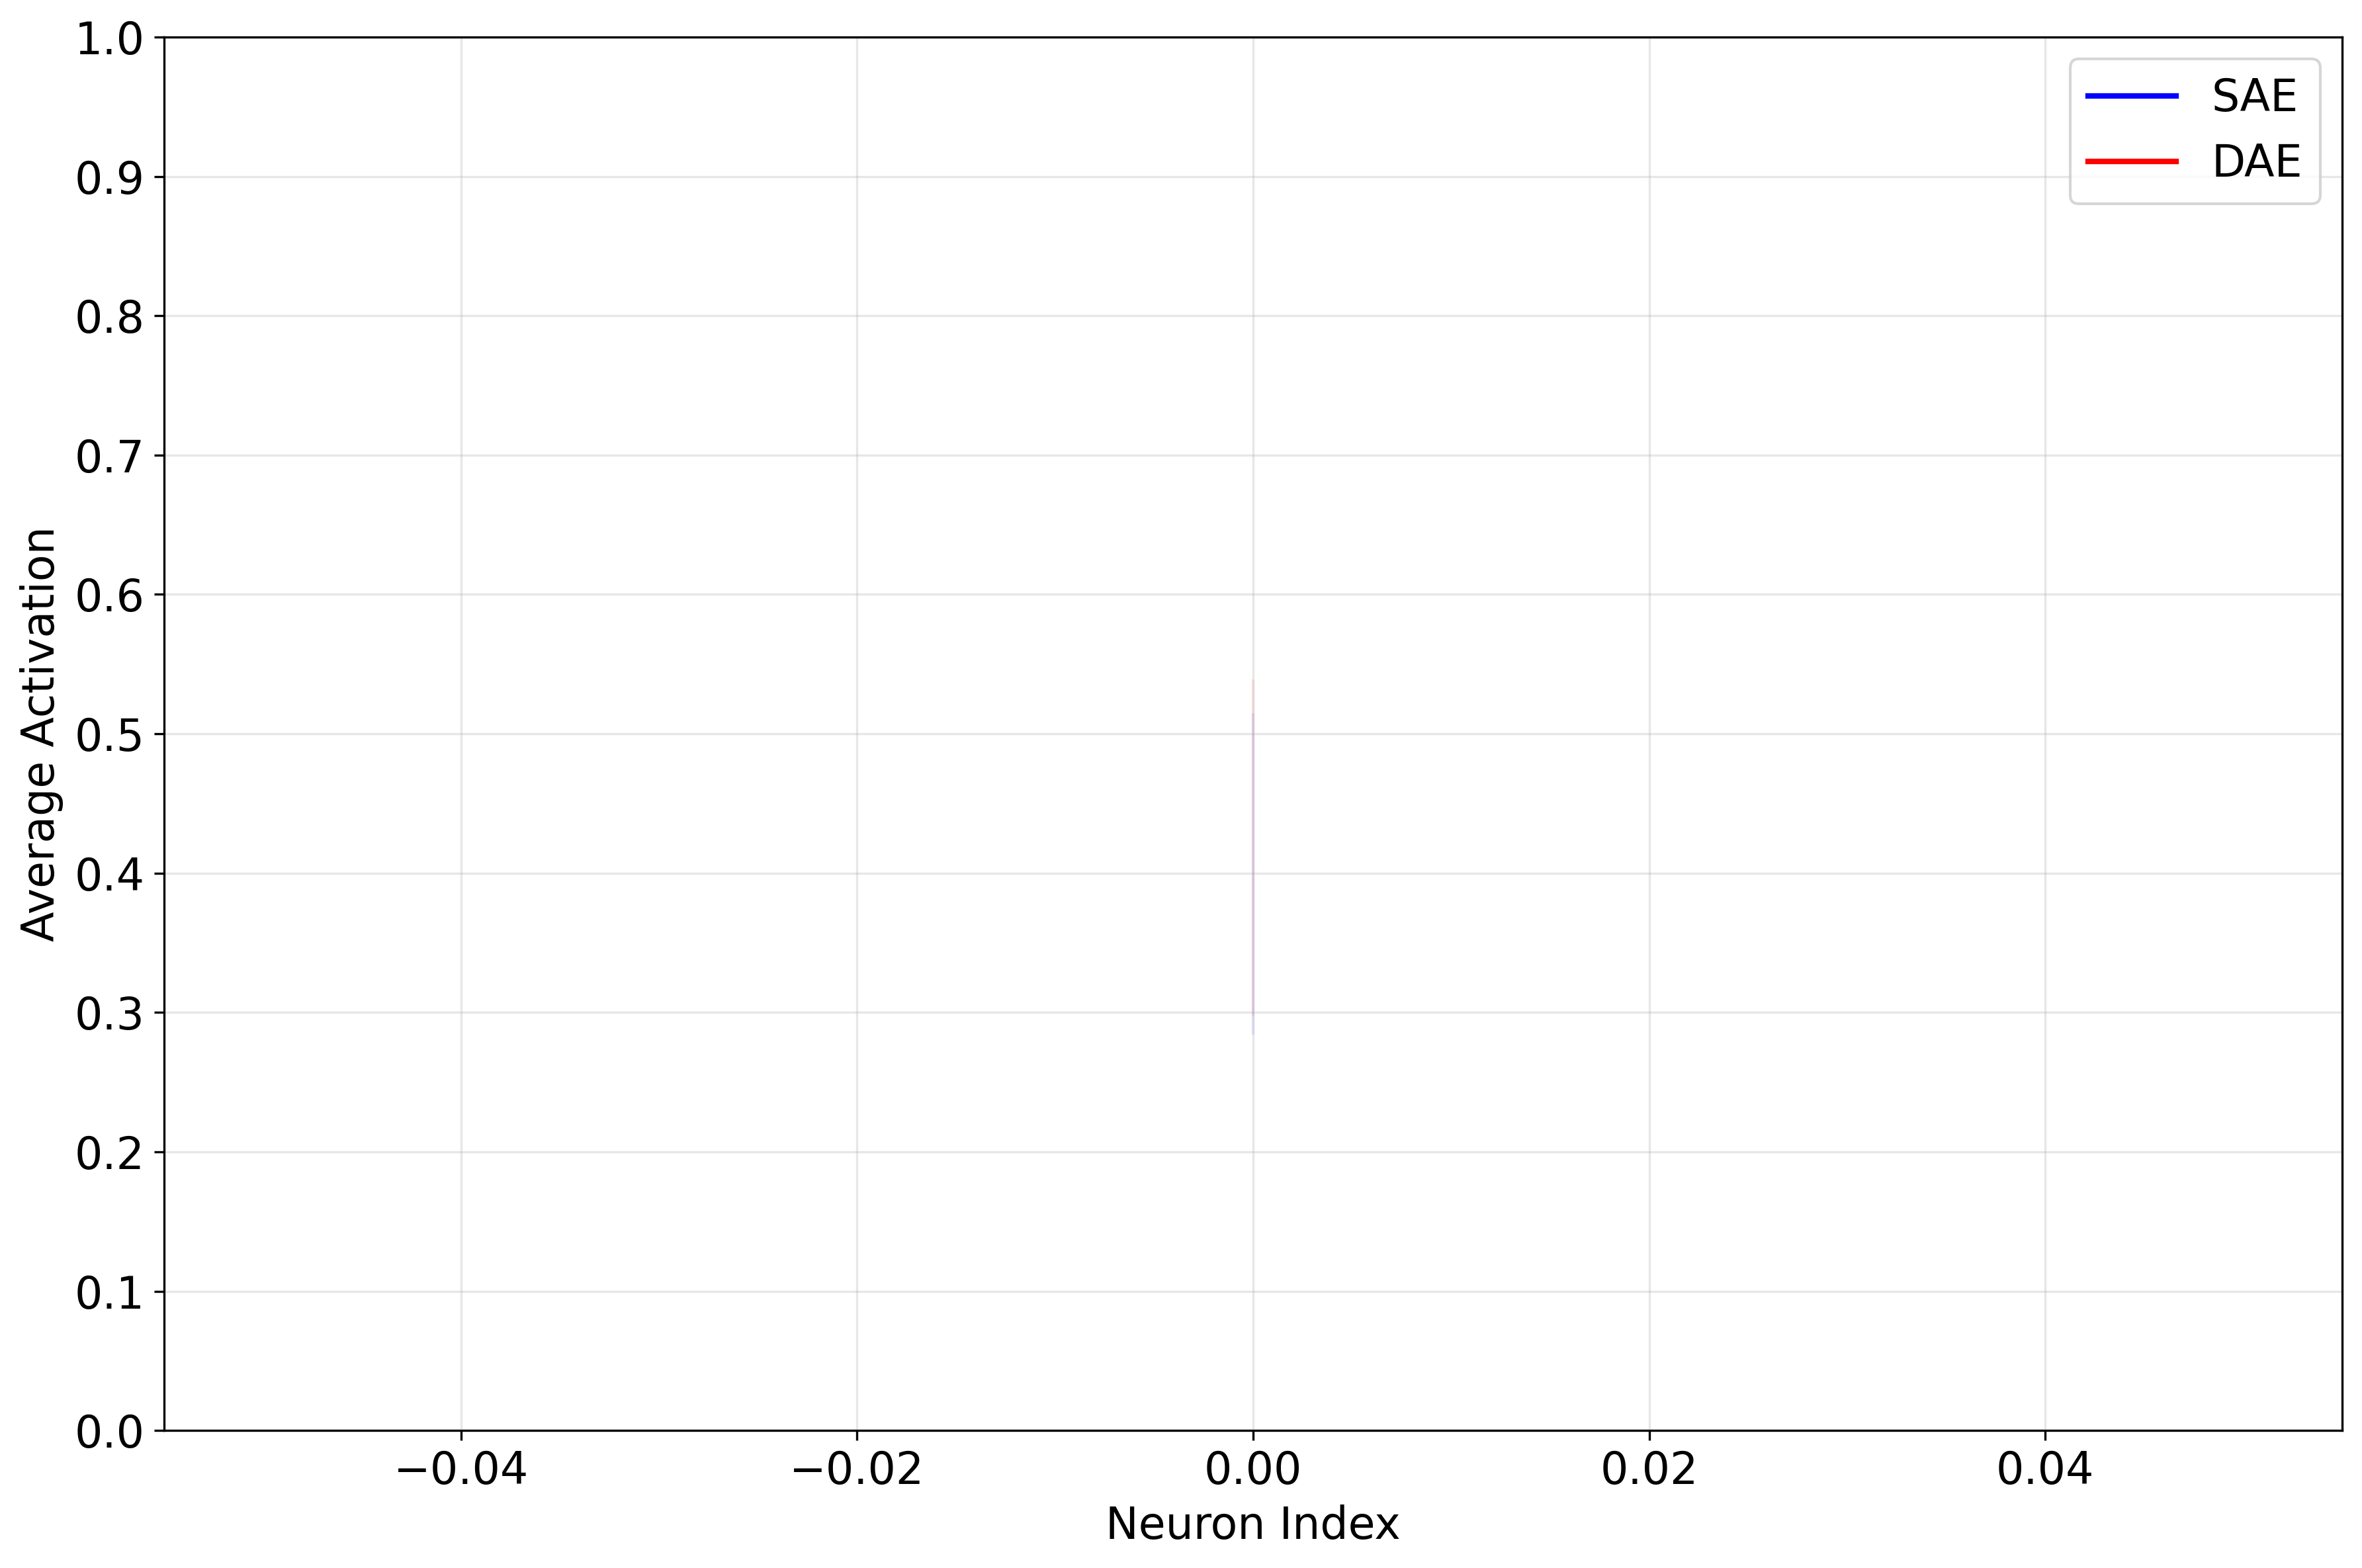

TypeError: plot_average_activation() takes 1 positional argument but 2 were given

In [11]:
plot_average_activation([results[0], results[1]])
plot_average_activation(results[2], results[3])

In [31]:
results = []

for iteration in tqdm(range(10), desc=f"Processing models", leave=False):
    modelpath = f'/home/david/sparsify_models/l_models/{iteration}'
    sae = load_model(modelpath, 'SAE', 49)
    dae = load_model(modelpath, 'DAE', 49)
    
    sae_activations, dae_activations = evaluate_models(test_images, sae, dae)
    results.append((sae_activations, dae_activations))

TypeError: load_model() missing 1 required positional argument: 'epoch'

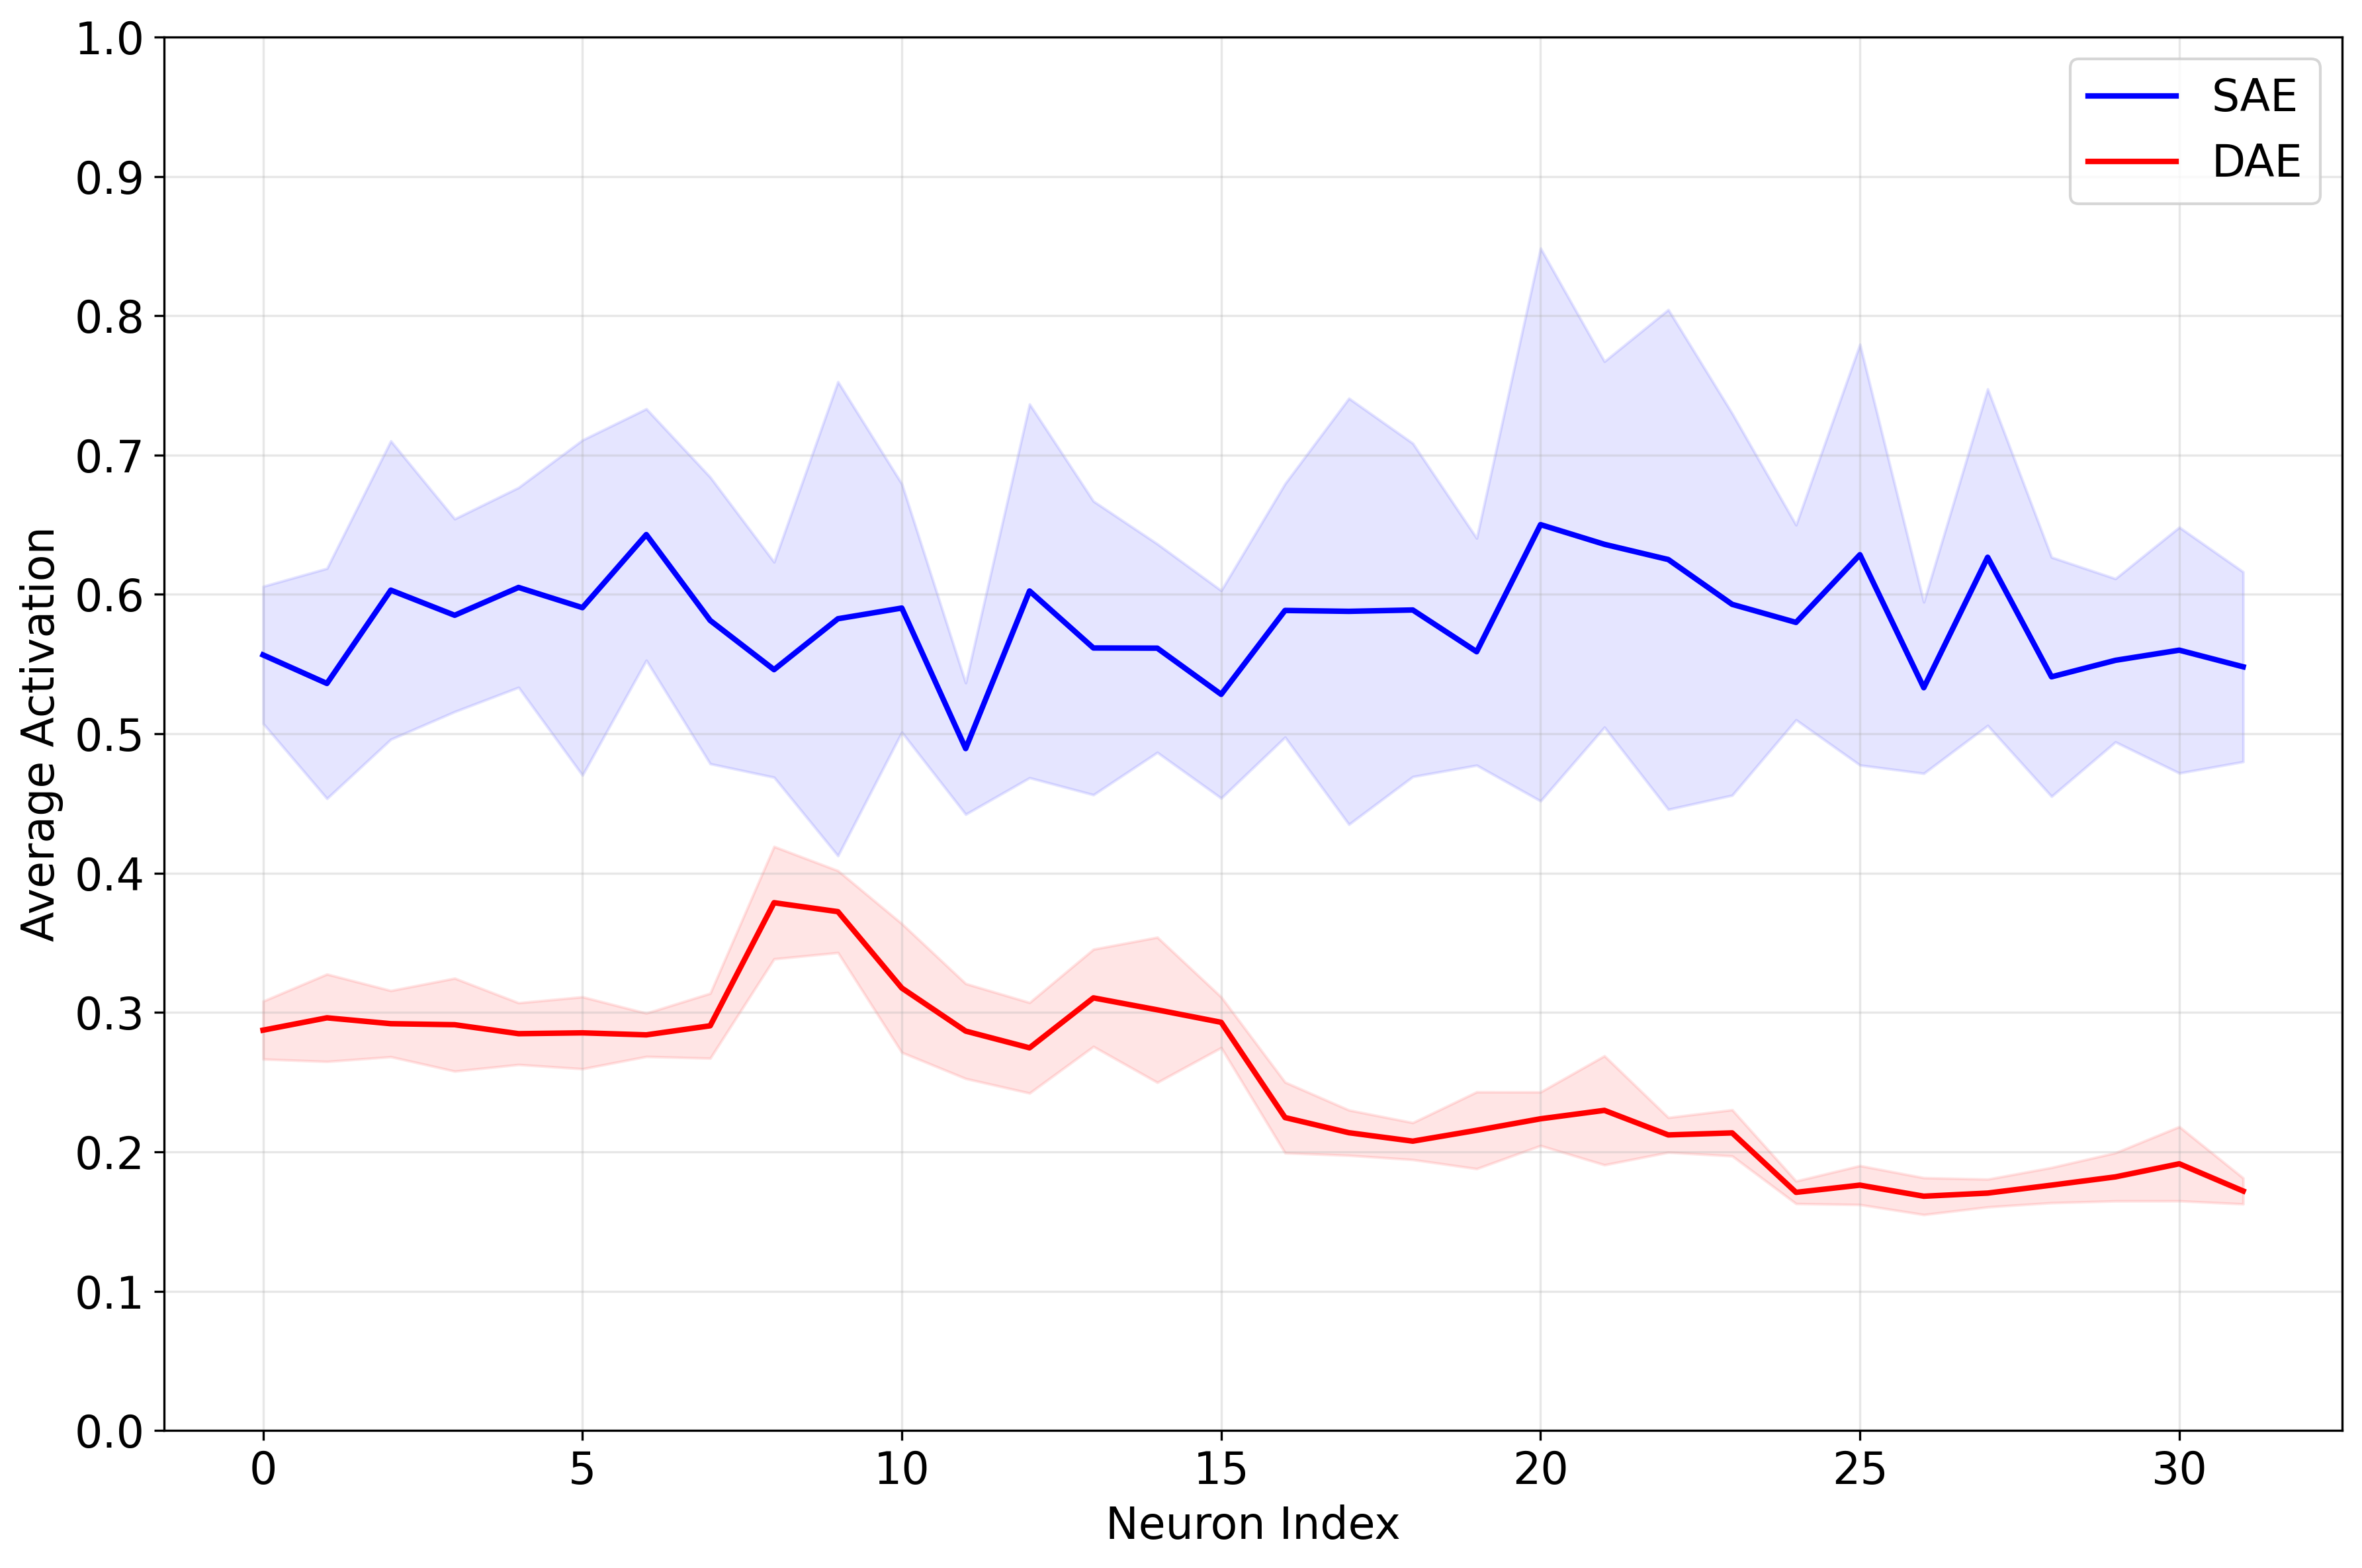

In [18]:
plot_average_activation(results)